<a href="https://colab.research.google.com/github/shin-hayabusasun/AI-python/blob/master/jikken3_2_ipynb_%E3%81%AE%E3%82%B3%E3%83%94%E3%83%BC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 実験３: オートエンコーダ (Autoencoders)



## ニューラルネットワークの復習

ニューラルネットワークは、人間の脳の仕組みにヒントを得たモデルで、入力に対して複雑な処理を行う「関数」として動作します。理論的には、十分な層とノードがあれば、どんな関数でも近似できる（これを「普遍近似性（universal approximation）」といいます）。

以下のような構造になっています：

* 入力層（Input layer）：データを受け取る（例：画像のピクセル情報など）
* 隠れ層（Hidden layer）：重み付きの計算と活性化関数により特徴を抽出
* 出力層（Output layer）：最終的な予測や出力を行う

各「層」では、次のような処理が行われます：

1. 各入力に対して重みをかけて合計（線形変換）
2. 活性化関数（ReLUやSigmoidなど）で非線形な処理を加える
3. 出力を次の層に渡す

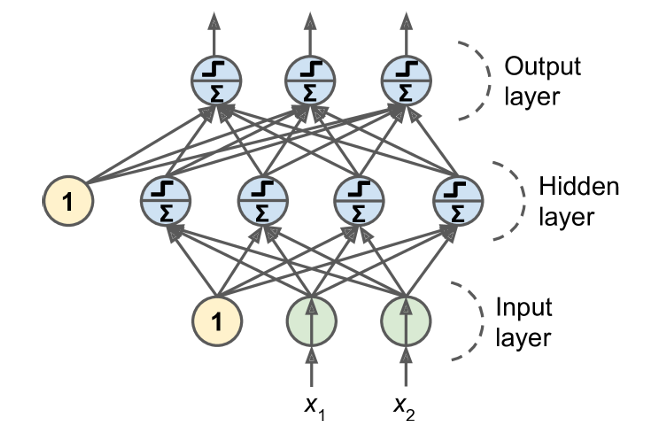

ニューラルネットワークは、大量のデータをもとに、重みを少しずつ調整しながら学習していきます。現代の機械学習では、「この処理、何でやればいいか分からないけど、データはたくさんある」というときに、とりあえずニューラルネットワークを入れてみるというのが実務的な発想です。

たとえば：
* 映像からの姿勢推定
* 音声認識
* 医療画像の異常検出
* ゲームAIの方策決定
* センサーデータからの予測や異常検知
* ...

つまり、ニューラルネットワークは、**「よく分からないが複雑な処理」を、データさえあれば置き換え可能な万能な部品（モジュール）**として広く使われています。

このリンクでニューラルネットワークの仕組みをよく見ましょう。

https://playground.tensorflow.org/

## オートエンコーダとは？

オートエンコーダ（Autoencoder）は、データをいったん圧縮し、そのあと再構成するニューラルネットワークです。この「圧縮してから元に戻す」というアイデアを、まず簡単な例で考えてみましょう。

### 効率的なデータ表現

次の二つの数字の列を覚える必要があるとします：

* 13, 92, 47, 68, 31
* 3, 6, 9, 12, 15, 18, 21, 24, 27, 30

2番目の列は長いにもかかわらず、「最初の数」「最後の数」「増加量（公差）」の三つの情報だけで簡単に思い出せます。つまり、本質的な情報は非常に少ないのです。

このように、「見た目には情報が多いけれど、実は本質的には単純」というデータに対して、小さな情報に“圧縮”することが可能です。

---

もうひとつ、興味深い例を挙げてみましょう。

プロ棋士は、盤面を一瞬見るだけで、その配置を驚くほど正確に思い出すことができます。一方で、将棋や囲碁を知らない人は、どこにどの駒があったかをすぐに忘れてしまいます。

なぜこんな違いがあるのでしょうか？将棋の知識がない人にとっては、盤面はただのランダムな記号の並びに見えます。一方でプロは、「この形はあの戦法の一部だ」「この位置取りは相手の罠だ」など、**意味のあるパターン（＝潜在的な特徴）**として理解しているのです。

つまりプロは、複雑な盤面を“圧縮”して理解しているとも言えます。これはオートエンコーダが潜在空間で重要な特徴を抽出するのと非常によく似ています。このように、オートエンコーダは「意味のある構造」があるデータに対して、その本質的なパターンを学び、少ない情報で表現する力を持っています。

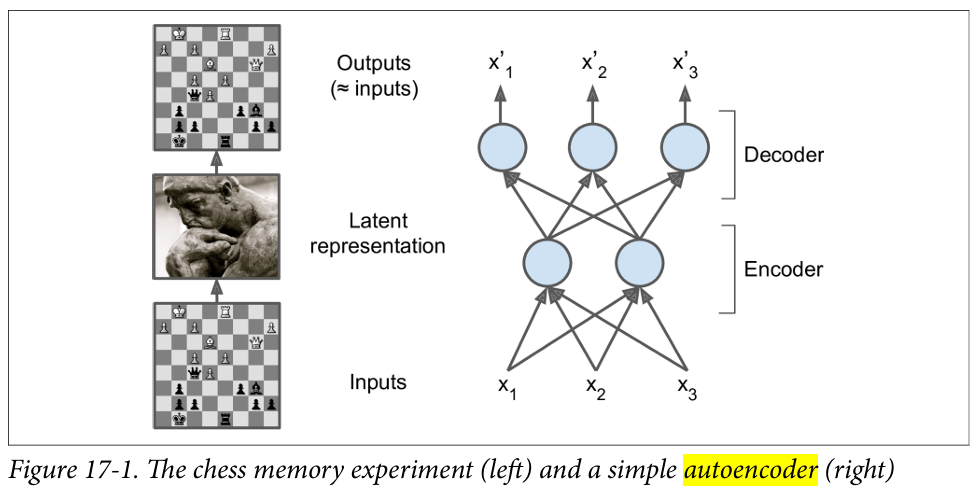

### ボトルネックと潜在空間
オートエンコーダは、次のような構造を持ちます：

* Encoder：元のデータを少ない次元に圧縮する（＝ボトルネック）
* Decoder：圧縮された情報から元のデータを再構成する

この圧縮された**中間表現（潜在空間 / latent space）**は、データの本質だけを残したコンパクトな表現です。私たちの「記憶」や「要約」と似ていて、オートエンコーダもできるだけ重要な情報を少ない形で保持しようとするのです。

### ボトルネックが狭くないと意味がない？

オートエンコーダでは、入力と出力が同じになるように学習します。
でも、ここでひとつ注意しなければならないことがあります。

もし、ボトルネック（潜在空間）のサイズが元のデータと同じくらい広い、あるいはそれ以上に広ければ…
ネットワークはただの「コピー装置」として動いてしまいます。

* すべての情報をそのまま通してしまい
* 意味のある特徴を学習せず
* 入力そのものをそのまま出力するだけになる

これはいわば、「何も理解せずに丸暗記した」状態です。

本当に意味のある学習ができているかを確認するには：

* ボトルネックを十分に狭くする
* 再構成がそこそこ上手くいっているかを見る

このとき、もし再構成が成功していれば、モデルは「限られた情報だけでデータを表現する力」を獲得しているということになります。これは、まさに「理解している」状態に近いのです。

## 線形オートエンコーダ：PCAとの関係

一般的に、オートエンコーダでは、活性化関数に ReLU や Sigmoid を使っています。
では、活性化関数を使わず、すべての層を線形（Linear）にした場合はどうなるでしょうか？

実はこのような線形オートエンコーダは、主成分分析（PCA）とほぼ同じことをしています。
* PCA は「元のデータを情報が最も多く含まれる方向に射影し、その空間で表現する」手法です
* 線形オートエンコーダも、「線形変換 → 低次元 → 線形変換で再構成」という構造になっており
* 活性化関数がないため、非線形な表現力がなく、できるのは線形な圧縮だけです

特に最小二乗誤差（損失関数）を使って、トレーニングした線形オートエンコーダのエンコーダ部分は PCA と同じ潜在空間を学習します。

実装して確認してみましょう。

まずは TensorFlow という深層学習のライブラリーを導入します。

In [ ]:
import sys
from packaging import version

IS_COLAB = "google.colab" in sys.modules
if IS_COLAB:
    import os
    os.environ["TF_USE_LEGACY_KERAS"] = "1"
    import tf_keras

import tensorflow as tf
assert version.parse(tf.__version__) >= version.parse("2.8.0")

トレーニングデータを生成します。

In [ ]:
import numpy as np
np.random.seed(4)

def generate_3d_data(m, w1=0.1, w2=0.3, noise=0.1):
    angles = np.random.rand(m) * 3 * np.pi / 2 - 0.5
    data = np.empty((m, 3))
    data[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * np.random.randn(m) / 2
    data[:, 1] = np.sin(angles) * 0.7 + noise * np.random.randn(m) / 2
    data[:, 2] = data[:, 0] * w1 + data[:, 1] * w2 + noise * np.random.randn(m)
    return data

X_train = generate_3d_data(60)
# Center the data around (0,0)
X_train = X_train - X_train.mean(axis=0, keepdims=0)

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure()
plt.figure(figsize=(12, 3.5))
ax = fig.add_subplot(121, projection='3d')
scatter = ax.scatter(X_train[:, 0], X_train[:, 1], X_train[:, 2])
plt.show()

オートエンコーダの実装はここからです。

In [ ]:
tf.random.set_seed(42)  # extra code – ensures reproducibility on CPU シード値

encoder = tf.keras.Sequential([tf.keras.layers.Dense(2)])
decoder = tf.keras.Sequential([tf.keras.layers.Dense(3)])
autoencoder = tf.keras.Sequential([encoder, decoder])

optimizer = tf.keras.optimizers.SGD(learning_rate=0.5)
autoencoder.compile(loss="mse", optimizer=optimizer)

トレーニングを行います。

In [ ]:
history = autoencoder.fit(X_train, X_train, epochs=500, verbose=False)

そして、トレーニングデータをエンコーダに入力します。

In [ ]:
codings = encoder.predict(X_train)

出力は三次元から二次元に**次元削減**されているデータです。

In [ ]:
plt.plot(codings[:,0], codings[:, 1], "b.")
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18, rotation=0)
plt.grid(True)
plt.show()

## スタック型オートエンコーダ

ここでは、もう少し深いネットワーク構造を持つ**スタック型（stacked）オートエンコーダ**を実装します。（トレーニングが時間かかるので、まずエンコーダの実装までのコードブロックを実行させてください）

ネットワーク構成

* 入力： 28×28 ピクセルのグレースケール画像（Fashion-MNIST）
* Flatten（784次元ベクトル）
* 中間層（100 → 30）
* 潜在ベクトル（30次元）
* デコーダ（30 → 100 → 784）
* 出力：再構成された28×28の画像
* 活性化関数は ReLU を使う

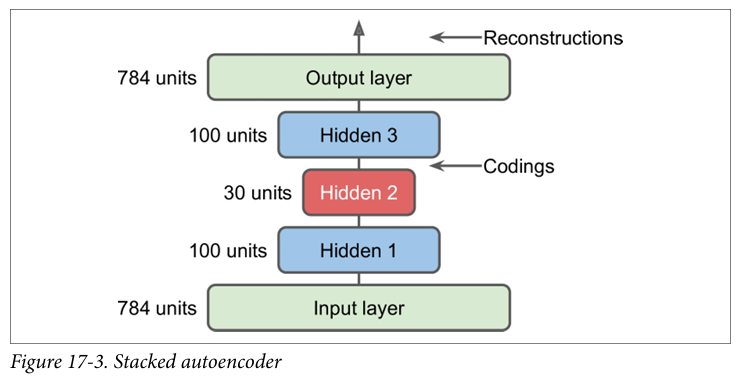

まずは Fashion MNIST データセットを導入します。これはネット通販の衣装や靴の画像データです。

In [ ]:
fashion_mnist = tf.keras.datasets.fashion_mnist.load_data()
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist
X_train_full = X_train_full.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

次はオートエンコーダの実装です。

In [ ]:
tf.random.set_seed(42)  # extra code – ensures reproducibility on CPU

stacked_encoder = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(30, activation="relu"),
])
stacked_decoder = tf.keras.Sequential([
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(28 * 28),
    tf.keras.layers.Reshape([28, 28])
])
stacked_ae = tf.keras.Sequential([stacked_encoder, stacked_decoder])

stacked_ae.compile(loss="mse", optimizer=tf.keras.optimizers.Nadam())
history = stacked_ae.fit(X_train, X_train, epochs=20,
                         validation_data=(X_valid, X_valid))

次は検証データセットを入力して、確認します。

In [ ]:
def plot_reconstructions(model, images=X_valid, n_images=5):
    reconstructions = np.clip(model.predict(images[:n_images]), 0, 1)
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plt.imshow(images[image_index], cmap="binary")
        plt.axis("off")
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plt.imshow(reconstructions[image_index], cmap="binary")
        plt.axis("off")

plot_reconstructions(stacked_ae)
plt.show()

## t-SNEによる潜在空間の可視化

オートエンコーダを訓練すると、各画像を30次元のベクトル（潜在ベクトル）に変換できるようになります。このベクトルには、その画像の「特徴」や「パターン」が凝縮されているはずです。

しかし、30次元の空間は人間にはイメージしづらいので、ここでは t-SNE（t-Distributed Stochastic Neighbor Embedding） という手法を使って、2次元に圧縮して可視化します。

### t-SNEとは？
t-SNE は、「近くにあるものは近く、遠くにあるものは遠く」という関係性を保ったまま、高次元のデータを低次元に落とす手法です。主に**可視化**のために使われるもので、分類や回帰には向きません。

* 同じカテゴリの画像（例：全て「靴」）は、近くに集まっているはず。
* 異なるカテゴリ（例：「シャツ」と「ブーツ」）は、離れた場所に分かれる傾向があります。

この可視化によって、「オートエンコーダが意味のある特徴を学習できたかどうか」を 直感的に確認することができます。

In [ ]:
from sklearn.manifold import TSNE

X_valid_compressed = stacked_encoder.predict(X_valid)
tsne = TSNE(init="pca", learning_rate="auto", random_state=42)
X_valid_2D = tsne.fit_transform(X_valid_compressed)

In [ ]:
X_valid_compressed #stacked_encoder.predict(x １セット)=>[30次元]　stacked_encoder.predict(x 10セット)=>[30次元][30次元]...10次元　行ごとに１つ

色（カテゴリ）はところどころだけど、だいたい同じ色のデータがクラスターになりました。しかし、どちらの色がどのカテゴリなのか、全然わかりません。

In [ ]:
X_valid_2D

In [ ]:
plt.scatter(X_valid_2D[:, 0], X_valid_2D[:, 1], c=y_valid, s=10, cmap="tab10")
plt.show()

ここで python の関数を定義して、データを指定して確認します。

In [ ]:
import matplotlib as mpl

plt.figure(figsize=(10, 8))
cmap = plt.cm.tab10
Z = X_valid_2D
Z = (Z - Z.min()) / (Z.max() - Z.min())  # normalize to the 0-1 range
plt.scatter(Z[:, 0], Z[:, 1], c=y_valid, s=10, cmap=cmap)
image_positions = np.array([[1., 1.]])
for index, position in enumerate(Z):
    dist = ((position - image_positions) ** 2).sum(axis=1)
    if dist.min() > 0.02: # if far enough from other images
        image_positions = np.r_[image_positions, [position]]
        imagebox = mpl.offsetbox.AnnotationBbox(
            mpl.offsetbox.OffsetImage(X_valid[index], cmap="binary"),
            position, bboxprops={"edgecolor": cmap(y_valid[index]), "lw": 2})
        plt.gca().add_artist(imagebox)

plt.axis("off")
plt.show()

確かに似ているものの潜在ベクトルが学習によって、潜在空間の中に近くなりました。

## 重みの共有

オートエンコーダでは、通常はエンコーダとデコーダに別々の重みを持たせています。
しかし実は、エンコーダの重みをデコーダにも使いまわすというアイデアがあります。これを**重みの共有（tied weights）**と呼びます。

エンコーダ部分で使った線形変換が $W$ という重み行列だとすると、
デコーダ部分ではその「逆の変換」をしたいので、転置行列 $W^t$ を使うという構成になります。

* エンコーダ： $h = W x + b$
* デコーダ： $x' = W^th + b'$

このようにすると、デコーダの重みはエンコーダの重みを転置したものになるので、学習すべきパラメータの数が減り、よりシンプルなモデルになります。

共有の理由は：
* パラメータの数を減らして、過学習を防ぐことができる
* 理論的には、最小の再構成誤差を達成する線形オートエンコーダは、重みを共有した構成になると証明されています（PCAとの関係）

In [ ]:
class DenseTranspose(tf.keras.layers.Layer):
    def __init__(self, dense, activation=None, **kwargs):
        super().__init__(**kwargs)
        self.dense = dense
        self.activation = tf.keras.activations.get(activation)

    def build(self, batch_input_shape):
        self.biases = self.add_weight(name="bias",
                                      shape=self.dense.input_shape[-1],
                                      initializer="zeros")
        super().build(batch_input_shape)

    def call(self, inputs):
        Z = tf.matmul(inputs, self.dense.weights[0], transpose_b=True)
        return self.activation(Z + self.biases)

In [ ]:
tf.random.set_seed(42)  # extra code – ensures reproducibility on CPU

dense_1 = tf.keras.layers.Dense(100, activation="relu")
dense_2 = tf.keras.layers.Dense(30, activation="relu")

tied_encoder = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    dense_1,
    dense_2
])

tied_decoder = tf.keras.Sequential([
    DenseTranspose(dense_2, activation="relu"),
    DenseTranspose(dense_1),
    tf.keras.layers.Reshape([28, 28])
])

tied_ae = tf.keras.Sequential([tied_encoder, tied_decoder])

# extra code – compiles and fits the model
tied_ae.compile(loss="mse", optimizer=tf.keras.optimizers.Nadam())
history = tied_ae.fit(X_train, X_train, epochs=10,
                      validation_data=(X_valid, X_valid))

In [ ]:
plot_reconstructions(tied_ae)
plt.show()

## 畳み込みオートエンコーダ

これまでのオートエンコーダは、すべてのピクセルを一列に並べて処理していましたが、画像のような「空間的な構造」を持つデータに対しては、**畳み込み（Convolution）**を使ったオートエンコーダが効果的です。

構造は基本的に同じですが、層がすべて**Conv2d（または ConvTranspose2d）**に置き換わるため、空間的な特徴を保ったまま圧縮・再構成することができます。

興味がある人は、以下のコードを使って畳み込み版を試してみてください。

In [ ]:
tf.random.set_seed(42)  # extra code – ensures reproducibility on CPU

conv_encoder = tf.keras.Sequential([
    tf.keras.layers.Reshape([28, 28, 1]),
    tf.keras.layers.Conv2D(16, 3, padding="same", activation="relu"),
    tf.keras.layers.MaxPool2D(pool_size=2),  # output: 14 × 14 x 16
    tf.keras.layers.Conv2D(32, 3, padding="same", activation="relu"),
    tf.keras.layers.MaxPool2D(pool_size=2),  # output: 7 × 7 x 32
    tf.keras.layers.Conv2D(64, 3, padding="same", activation="relu"),
    tf.keras.layers.MaxPool2D(pool_size=2),  # output: 3 × 3 x 64
    tf.keras.layers.Conv2D(30, 3, padding="same", activation="relu"),
    tf.keras.layers.GlobalAvgPool2D()  # output: 30
])
conv_decoder = tf.keras.Sequential([
    tf.keras.layers.Dense(3 * 3 * 16),
    tf.keras.layers.Reshape((3, 3, 16)),
    tf.keras.layers.Conv2DTranspose(32, 3, strides=2, activation="relu"),
    tf.keras.layers.Conv2DTranspose(16, 3, strides=2, padding="same",
                                    activation="relu"),
    tf.keras.layers.Conv2DTranspose(1, 3, strides=2, padding="same"),
    tf.keras.layers.Reshape([28, 28])
])
conv_ae = tf.keras.Sequential([conv_encoder, conv_decoder])

# extra code – compiles and fits the model
conv_ae.compile(loss="mse", optimizer=tf.keras.optimizers.Nadam())
history = conv_ae.fit(X_train, X_train, epochs=10,
                      validation_data=(X_valid, X_valid))

In [ ]:
plot_reconstructions(conv_ae)
plt.show()

## ノイズ除去オートエンコーダ

現実世界のデータには、ノイズや欠損が含まれることがよくあります。
ノイズ除去オートエンコーダ（Denoising Autoencoder）は、そうした不完全なデータから本来の構造を復元する能力を身につけるための手法です。もうひとつの考え方は、加えたノイズが潜在空間の表現をより大事な特徴を学ばせます。これはまさに特徴抽出ということです。

* 通常のオートエンコーダは「入力画像＝出力画像」として学習しますが、
ノイズ除去オートエンコーダでは、「ノイズ付き画像 → 元画像」の変換を学習します。
* これは、「壊れた画像から情報を回復する能力」をネットワークに身につけさせることを意味します。

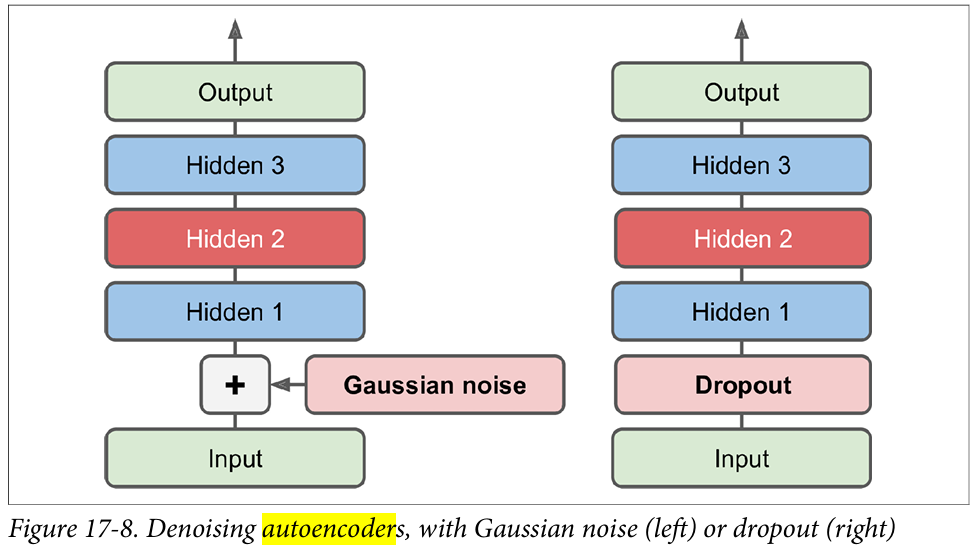

In [ ]:
tf.random.set_seed(42)  # extra code – ensures reproducibility on CPU

dropout_encoder = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    # tf.keras.layers.Dropout(0.5),
    tf.keras.layers.GaussianNoise(0.2),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(30, activation="relu")
])
dropout_decoder = tf.keras.Sequential([
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(28 * 28),
    tf.keras.layers.Reshape([28, 28])
])
dropout_ae = tf.keras.Sequential([dropout_encoder, dropout_decoder])

# extra code – compiles and fits the model
dropout_ae.compile(loss="mse", optimizer=tf.keras.optimizers.Nadam())
history = dropout_ae.fit(X_train, X_train, epochs=10,
                         validation_data=(X_valid, X_valid))

In [ ]:
tf.random.set_seed(42)
# dropout = tf.keras.layers.Dropout(0.5)
noise = tf.keras.layers.GaussianNoise(0.2)
plot_reconstructions(dropout_ae, noise(X_valid, training=True))
plt.show()

## 変分オートエンコーダ（VAE: Variational Autoencoder）

オートエンコーダを拡張して、新しいデータを生成できるようにしたモデルが、**変分オートエンコーダ（VAE）**です。

通常のオートエンコーダとの違い：
* 通常のオートエンコーダは、1つの画像を**決まったベクトル（潜在変数）**に圧縮します
* それに対し、VAE は各画像に対して**確率分布（平均と分散）**を学習します
* 潜在空間には「この画像はこのあたりに属していそう」という曖昧さ・多様性を反映できます
* 学習時には、その分布からランダムにサンプリングした値を使って画像を再構成します

何ができるのか？
* 潜在空間における「滑らかな移動」が意味を持つようになります（例：靴 → サンダル → ブーツ）
* 学習後は、潜在空間からランダムにサンプルすることで、まったく新しい画像を生成することができます

技術的な違い（簡単に）
* VAE は損失関数に、以下の2つを含みます：
  1. 再構成誤差（通常のオートエンコーダと同じ）
  2. KLダイバージェンス（分布が標準正規分布に近づくようにする項）

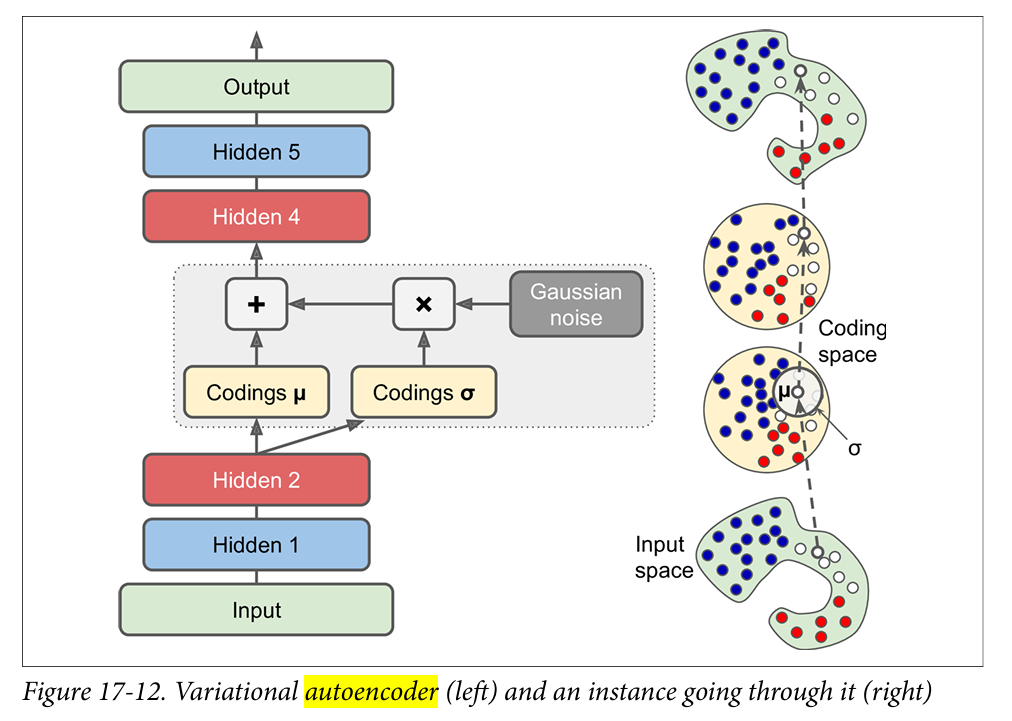

In [ ]:
class Sampling(tf.keras.layers.Layer):
    def call(self, inputs):
        mean, log_var = inputs
        return tf.random.normal(tf.shape(log_var)) * tf.exp(log_var / 2) + mean

In [ ]:
tf.random.set_seed(41)  # extra code – ensures reproducibility on CPU

codings_size = 10

inputs = tf.keras.layers.Input(shape=[28, 28])
Z = tf.keras.layers.Flatten()(inputs)
Z = tf.keras.layers.Dense(150, activation="relu")(Z)
Z = tf.keras.layers.Dense(100, activation="relu")(Z)
codings_mean = tf.keras.layers.Dense(codings_size)(Z)  # μ
codings_log_var = tf.keras.layers.Dense(codings_size)(Z)  # γ
codings = Sampling()([codings_mean, codings_log_var])
variational_encoder = tf.keras.Model(
    inputs=[inputs], outputs=[codings_mean, codings_log_var, codings])

In [ ]:
decoder_inputs = tf.keras.layers.Input(shape=[codings_size])
x = tf.keras.layers.Dense(100, activation="relu")(decoder_inputs)
x = tf.keras.layers.Dense(150, activation="relu")(x)
x = tf.keras.layers.Dense(28 * 28)(x)
outputs = tf.keras.layers.Reshape([28, 28])(x)
variational_decoder = tf.keras.Model(inputs=[decoder_inputs], outputs=[outputs])

In [ ]:
_, _, codings = variational_encoder(inputs)
reconstructions = variational_decoder(codings)
variational_ae = tf.keras.Model(inputs=[inputs], outputs=[reconstructions])

In [ ]:
latent_loss = -0.5 * tf.reduce_sum(
    1 + codings_log_var - tf.exp(codings_log_var) - tf.square(codings_mean),
    axis=-1)
variational_ae.add_loss(tf.reduce_mean(latent_loss) / 784.)

In [ ]:
variational_ae.compile(loss="mse", optimizer=tf.keras.optimizers.Nadam())
history = variational_ae.fit(X_train, X_train, epochs=25, batch_size=128,
                             validation_data=(X_valid, X_valid))

In [ ]:
plot_reconstructions(variational_ae)
plt.show()

VAE を使って新しい画像を生成しましょう。

In [ ]:
tf.random.set_seed(42)  # extra code – ensures reproducibility on CPU

codings = tf.random.normal(shape=[3 * 7, codings_size])
images = variational_decoder(codings).numpy()

In [ ]:
def plot_multiple_images(images, n_cols=None):
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    if images.shape[-1] == 1:
        images = images.squeeze(axis=-1)
    plt.figure(figsize=(n_cols, n_rows))
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image, cmap="binary")
        plt.axis("off")

plot_multiple_images(images, 7)
plt.show()

In [ ]:
tf.random.set_seed(42)  # extra code – ensures reproducibility on CPU

codings = np.zeros([7, codings_size])
codings[:, 6] = np.linspace(-0.8, 0.8, 7)  # axis 3 looks best in this case
images = variational_decoder(codings).numpy()

In [ ]:
# extra code – this cell generates and saves Figure 17–13
plot_multiple_images(images)
plt.show()

# 演習課題

1. ボトルネック（潜在空間のサイズ）を変えてみよう。エンコーダの最後の出力サイズを変更してみてください。
  * 圧縮率と再構成のクオリティのトレードオフはどうなりますか？
  * 小さすぎるとどんな問題が起きますか？
2. 層を追加・削除してみよう。エンコーダやデコーダに隠れ層を1つ削除して、学習してみましょう。
  * 学習のスピードは変わりますか？
  * 再構成結果にはどんな影響がありますか？
3. エンコーダの出力を可視化してみましょう。エンコーダの出力（潜在ベクトル）を2次元または3次元の散布図（scatter plot）で表示しましょう。
  * ```predict```関数を使って、エンコーダの出力を取り出し、ラベルごとに色分けしてみてください
  * 同じカテゴリの画像は近くに集まりますか？
4. t-SNE を使って可視化してみよう
5. 他のデータセット（例：MNIST）で試してみよう